## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-10-08 06:53:42--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.233.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.233.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  69.8MB/s    in 4.8s    

2020-10-08 06:53:47 (66.8 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>

```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

# Get torch summary to show the summary and the number 
# of training parameters; This can also be used 
# as in initial validation of the network architecture
!pip install torchsummary
from torchsummary import summary

# Set the device to either use cpu or gpu
device = 'cuda:0' if torch.cuda.is_available () else 'cpu'

# Import the models
import models
from importlib import reload; reload (models);

# Define the architecture to use
arch = 'NaimishNet' # Values: 'SimpleNet', 'NaimishNet'

if arch == 'SimpleNet':
    Net = models.SimpleNet
    drop_prob = 0.25
    input_size = (1, 224, 244)
    
    net = Net(drop_prob=drop_prob).to (device)
else: 
    Net = models.NaimishNet
    input_size = (1, 96, 96)
    # Uses an increasing dropout
    drop_prob = None
    
    # Define the network
    # Batch normalization has been disabled
    net = Net(drop_prob=drop_prob, use_batch_norm=False).to (device)
    

# Initialize the weights and biases
# Using Kaiming, He Initialization instead of Xavier
# as ReLU is used as the activation function
net.apply (models.init_weights_biases)
    
print(net)
summary (net, input_size)

NaimishNet(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp4): MaxPool2d(kernel_size=2, stride=2, padd

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor
from data_load import RandomShear, RandomScale, RandomRotate

## Define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop

# Added Random Shear, which might help generalize better
# Edited Random Crop to crop the images at random and at random locations
# Crops at the most 20% of the size

# Added Random Rotate to rotate the image by at most 25 degrees on either side
# 25 was chosen so that the rotation preserves most the face
# Added Random Scale to zoom-in at the center of the image
# Done by scaling with some scaling factor and then cropping the center region
train_transform = transforms.Compose ([
    Rescale (input_size [-1]),
    RandomShear (input_size [-1]),
    RandomScale (input_size [-1]),
    RandomRotate (input_size [-1]),
    RandomCrop (input_size [-1], input_size [-1]-int (input_size [-1]*0.2)),
    Normalize (),
    ToTensor ()
])

# On the test data just perform the resizing and normalization
test_transform = transforms.Compose ([
    Rescale (input_size [-1]),
    Normalize (),
    ToTensor ()
])

# testing that you've defined a transform
assert(train_transform is not None), 'Define a train_transform'
assert(test_transform is not None), 'Define a test_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=train_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# Define the batch_size
# Used both by train and test
batch_size = 32

In [7]:
# load training data in batches
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          #num_workers=4 # Disabled this as it throws an error
                         )


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=test_transform)



In [9]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          #num_workers=4 # Disabled this as it throws an error
                        )

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # Disable gradients
        with torch.no_grad ():
            net.eval ()
            
            # convert images to FloatTensors
            images = images.type(torch.FloatTensor if device=='cpu' else torch.cuda.FloatTensor)

            # forward pass to get net output
            output_pts = net(images)

            # reshape to batch_size x 68 x 2 pts
            output_pts = output_pts.view(output_pts.size()[0], 68, -1)

            # break after first image is tested
            if i == 0:
                return images, output_pts, key_pts
            
            net.train ()    

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 96, 96])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, ax, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    ax.imshow(image, cmap='gray')
    ax.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        ax.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')
        
    ax.axis ('off')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

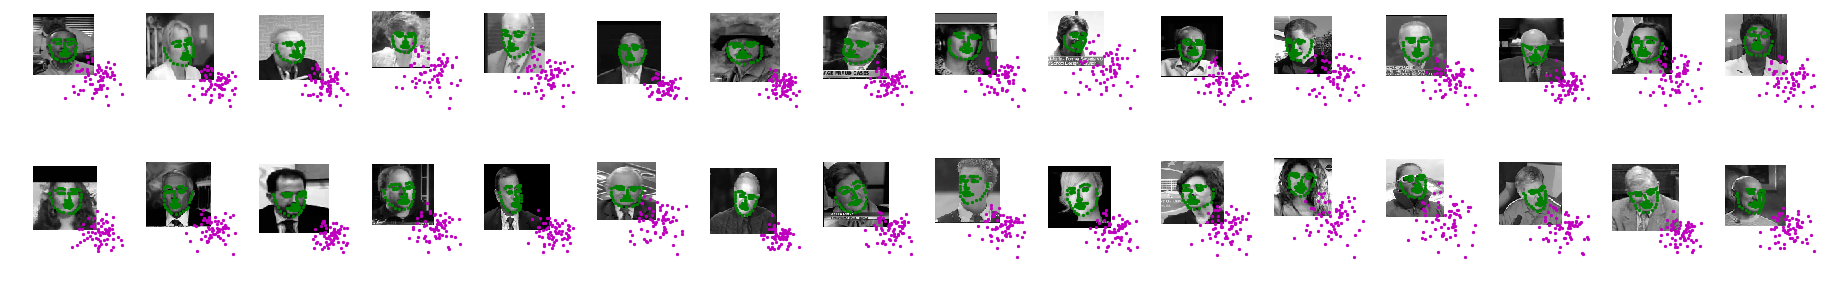

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    fig = plt.figure (figsize=(batch_size, 5))
    
    for i in range(batch_size):
        #plt.figure(figsize=(20,10))
        #ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy() if device=='cpu' else image.cpu ().numpy ()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy() if device=='cpu' else predicted_key_pts.cpu ().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
            
            
        # Get the axis on which to plot
        ax = fig.add_subplot (2, batch_size//2, i+1)
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ax, ground_truth_pts)

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts, batch_size)

- The predictions are random and just a point, as expected before training the model

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## TODO: Define the loss and optimization
import torch.optim as optim

# Set the loss function to use
loss_fn = 'RMSE' # other values 'MSE', 'RMSE'

if loss_fn in ['MSE', 'RMSE']:
    # For RMSE, the sqrt is taken while training
    criterion = nn.MSELoss ()
elif loss_fn == 'L1':
    # L1 might be preferred as it not too affected by outliers
    criterion = nn.L1Loss ()

# Define the optmizer to use
optimizer = optim.Adam (net.parameters (), lr=0.001)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
from tqdm import tqdm_notebook as tqdm

def train_net(n_epochs):

    # prepare the net for training
    net.train()
    
    # Store the losses to get the average loss over each epochs
    avg_loss = {'train': [], 'test': []}
    
    # Show the progress
    #epoch_pbar = tqdm (range(n_epochs))

    for epoch in range(n_epochs): #epoch_pbar:  # loop over the dataset multiple times
        
        running_loss = 0.0
        avg_loss ['train'].append (0.0)

        # Batch progress
        #batch_pbar = tqdm (train_loader)
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate (train_loader): #enumerate(batch_pbar):
            # Set to training mode
            net.train ()
            
            # get the input images and their corresponding labels
            images = data['image'].to (device)
            key_pts = data['keypoints'].to (device)

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor if device=='cpu' else torch.cuda.FloatTensor)
            images = images.type(torch.FloatTensor if device=='cpu' else torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            # Take the root of it, since the criteria is MSE to make it RMSE
            # The loss can be either of L1, MSE, or RMSE
            loss = criterion(output_pts, key_pts)
            if loss_fn == 'RMSE':
                loss = torch.sqrt (loss)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # print it out only on the last interation
            if batch_i == len (train_loader)-1:
                #batch_pbar.set_description (
                print (
                    f'Epoch: {epoch + 1}, Batch: {batch_i+1}, Loss: {loss.item ():.3f}'
                )

            # Store the loss for later
            avg_loss ['train'] [-1] += loss.item ()
    
        # Get the test loss after each epoch
        with torch.no_grad ():
            # Set it to evalution mode
            net.eval ()

            # Add up the loss for every batch
            avg_loss ['test'].append (0.0)

            for test_data in test_loader:
                # get the input images and their corresponding labels
                images = test_data['image'].to (device)
                key_pts = test_data['keypoints'].to (device)

                # flatten pts
                key_pts = key_pts.view(key_pts.size(0), -1)

                # convert variables to floats for regression loss
                key_pts = key_pts.type(torch.FloatTensor if device=='cpu' else torch.cuda.FloatTensor)
                images = images.type(torch.FloatTensor if device=='cpu' else torch.cuda.FloatTensor)

                # Get the predictions
                pred_pts = net.forward (images)

                # Get the loss
                avg_loss ['test'] [-1] += torch.sqrt (criterion (pred_pts, key_pts)).item ()

            # Set it back to training mode
            net.train ()

    # Divide the loss by the total no of images
    avg_loss ['train'] = np.array (avg_loss ['train']) / len (train_loader)
    avg_loss ['test'] = np.array (avg_loss ['test']) / len (test_loader)
            
    #print ('Average loss of each epoch: \n', avg_loss)
    # Plot the losses
    plt.figure (figsize=(7, 5))
    plt.plot (avg_loss ['train'], label='Training loss')
    plt.plot (avg_loss ['test'], label='Test loss')
    plt.legend ()
    plt.show ()
    
    print('Finished Training')
    
    return avg_loss

Epoch: 1, Batch: 109, Loss: 0.302
Epoch: 2, Batch: 109, Loss: 0.249
Epoch: 3, Batch: 109, Loss: 0.162
Epoch: 4, Batch: 109, Loss: 0.212
Epoch: 5, Batch: 109, Loss: 0.200
Epoch: 6, Batch: 109, Loss: 0.310
Epoch: 7, Batch: 109, Loss: 0.185
Epoch: 8, Batch: 109, Loss: 0.138
Epoch: 9, Batch: 109, Loss: 0.166
Epoch: 10, Batch: 109, Loss: 0.186
Epoch: 11, Batch: 109, Loss: 0.157
Epoch: 12, Batch: 109, Loss: 0.272
Epoch: 13, Batch: 109, Loss: 0.233
Epoch: 14, Batch: 109, Loss: 0.207
Epoch: 15, Batch: 109, Loss: 0.181
Epoch: 16, Batch: 109, Loss: 0.267
Epoch: 17, Batch: 109, Loss: 0.190
Epoch: 18, Batch: 109, Loss: 0.161
Epoch: 19, Batch: 109, Loss: 0.162
Epoch: 20, Batch: 109, Loss: 0.205
Epoch: 21, Batch: 109, Loss: 0.157
Epoch: 22, Batch: 109, Loss: 0.223
Epoch: 23, Batch: 109, Loss: 0.115
Epoch: 24, Batch: 109, Loss: 0.175
Epoch: 25, Batch: 109, Loss: 0.108
Epoch: 26, Batch: 109, Loss: 0.177
Epoch: 27, Batch: 109, Loss: 0.176
Epoch: 28, Batch: 109, Loss: 0.296
Epoch: 29, Batch: 109, Loss: 

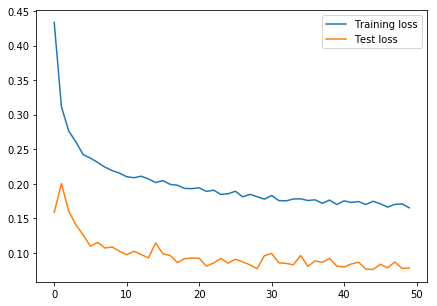

Finished Training


In [16]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    avg_loss = train_net(n_epochs)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 96, 96])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


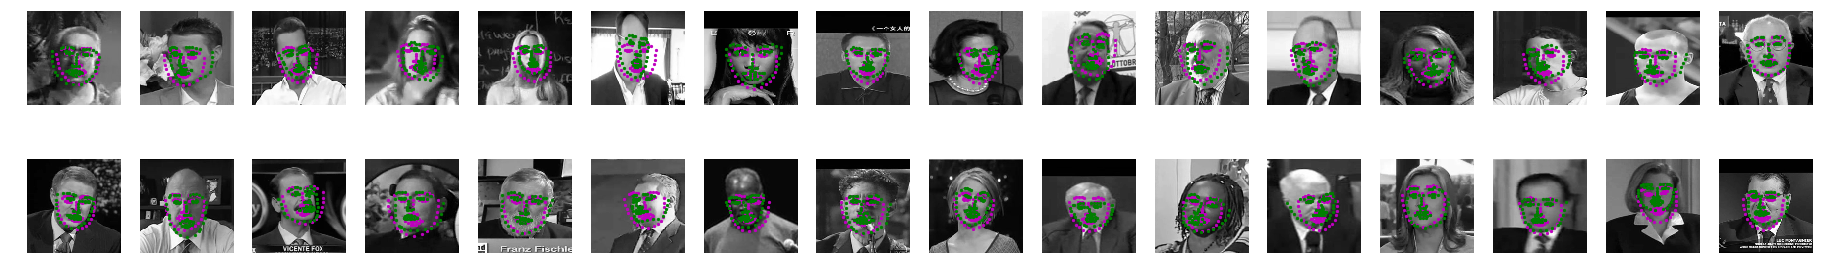

In [18]:
## Visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts, batch_size)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [19]:
## TODO: change the name to something unique for each new model
model_dir = 'saved_models/'
model_name = f'keypoints_model_{arch}_epochs_{n_epochs}_batch_size_{batch_size}_with_init_{loss_fn}.pt'

# Create a dictionary with the attributes to save along with the state_dict
model_save = {
    'state_dict': net.state_dict (),
    'n_epochs': n_epochs,
    'avg_training_loss': avg_loss ['train'],
    'avg_test_loss': avg_loss ['test']
}

# after training, save your model parameters in the dir 'saved_models'
torch.save(model_save, model_dir+model_name)

**Issues**
- ~~The network seems to work well when the person is looking forward, but doesn't do so well when the faces are tilted~~
    - Augmentation, such as RandomShear and RandomRotate helped stabalize this

#### Check the which model performed better

In [20]:
def get_test_loss (net):
    ''' Calculate the test loss for the given network '''
    
    # Get the test loss after each epoch
    with torch.no_grad ():
        # Set it to evalution mode
        net.eval ()

        # Add up the loss for every batch
        #avg_loss ['test'].append (0.0)
        avg_loss = 0.0
        
        for test_data in test_loader:
            # get the input images and their corresponding labels
            images = test_data['image'].to (device)
            key_pts = test_data['keypoints'].to (device)

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor if device=='cpu' else torch.cuda.FloatTensor)
            images = images.type(torch.FloatTensor if device=='cpu' else torch.cuda.FloatTensor)

            # Get the predictions
            pred_pts = net.forward (images)

            # Get the loss
            #avg_loss ['test'] [-1] += torch.sqrt (criterion (pred_pts, key_pts)).item ()
            avg_loss += torch.sqrt (criterion (pred_pts, key_pts)).item ()

        # Set it back to training mode
        net.train ()
    
    # Divide by the number of samples
    return avg_loss / len (test_loader)

In [21]:
# Choose the best model based on the test loss scores
import glob

# Save the training and test losses
training_loss = {}
test_loss = []

# Iterate through the saved files
# Compare only a few models, with the latest changes
for f in [
    'saved_models/keypoints_model_NaimishNet_epochs_50_batch_size_32_with_init_RMSE.pt',
    'saved_models/keypoints_model_NaimishNet_epochs_50_batch_size_32_with_init_L1.pt',
    'saved_models/keypoints_model_NaimishNet_epochs_50_batch_size_32_with_init.pt',
    'saved_models/keypoints_model_NaimishNet_epochs_50_batch_size_32_1.pt']:
    
    # Load the checkpoint
    checkpoint = torch.load (f, map_location=device)
    
    # Get the losses
    training_loss [
        f.split ('/') [-1].split ('NaimishNet_') [1].split ('.') [0]
    ] = checkpoint ['avg_training_loss']
    
    try:
        # See if the checkpooint has saved test losses
        # Saved only for one the checkpoints
        test_loss.append (checkpoint ['avg_test_loss'])
    except KeyError:
        # If not found compute it
        # Initialize a temporary network
        temp_net = Net ()
        
        # Set the weights
        temp_net.load_state_dict (checkpoint ['state_dict'])
        test_loss.append ([get_test_loss (temp_net)])

        # Delete the temporary network
        del temp_net

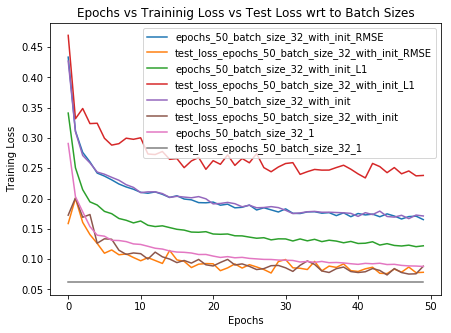

In [22]:
plt.figure (figsize=(7, 5))
for (k, v), t in zip (training_loss.items (), test_loss):
    plt.plot (v, label=k)
    plt.plot ([t]*50 if len (t) == 1 else t, label=f'test_loss_{k}')
plt.legend ()
plt.title ('Epochs vs Traininig Loss vs Test Loss wrt to Batch Sizes')
plt.ylabel ('Training Loss'); plt.xlabel ('Epochs');

**Note**: 
- The previous execution didn't save the test loss, used the final test loss across each epoch (the line for `test_loss_epochs_50_batch_size_32_1` in the above plot)
- Runs `epochs_50_batch_size_32_with_init_RMSE` and `epochs_50_batch_size_32_with_init` is a rerun of the same network and parameters (hence the losses are very similar)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.


### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 
- _Optimizer_: Using SGD with momentum as the optimizer, since the momentum could help get out of the local minima
    - Initially the momentum was set to `0.9`, better to use Adam instead
    
    _Results of using SGD with momemtum 0.9_ (perhaps would require to tune momentum better)
    ```
    Epoch: 1, Batch: 109, Loss: 0.558: 100% 109/109 [00:55<00:00, 2.51it/s]
    Epoch: 2, Batch: 109, Loss: 0.729: 100% 109/109 [00:56<00:00, 2.47it/s]
    Epoch: 3, Batch: 109, Loss: 0.521: 100% 109/109 [00:56<00:00, 2.46it/s]
    Epoch: 4, Batch: 109, Loss: 0.730: 100% 109/109 [00:56<00:00, 2.47it/s]
    Epoch: 5, Batch: 109, Loss: 0.432: 100% 109/109 [00:56<00:00, 2.47it/s]
    ```
    
    _Results of using Adam_ (Converges a lot faster)
    ```
    Epoch: 1, Batch: 109, Loss: 0.525: 100% 109/109 [00:56<00:00, 2.43it/s]
    Epoch: 2, Batch: 109, Loss: 0.465: 100% 109/109 [00:55<00:00, 2.45it/s]
    Epoch: 3, Batch: 109, Loss: 0.385: 100% 109/109 [00:55<00:00, 2.49it/s]
    Epoch: 4, Batch: 109, Loss: 0.478: 100% 109/109 [00:56<00:00, 2.41it/s]
    Epoch: 5, Batch: 109, Loss: 0.710: 100% 109/109 [00:56<00:00, 2.43it/s]
    Epoch: 6, Batch: 109, Loss: 0.400: 100% 109/109 [00:56<00:00, 2.48it/s]
    ```
    
    - Learning rate was set to a low default of 0.001 to avoid missing the minima

- The _loss function_ used is MSELoss (defined as the criteria) and the root taken after to get RSME, since the keypoints predicted are numeric (regression). (Also the attached paper on the Facial Keypoints used RSME).
    - Also tried L1 loss, though the train losses were less (lesser compared to when trained using RMSE, the test losses were high)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 
1. Initially started with a network as shown below, with the final layers being fully connected layers instead of passing it through a Global Average Pooling (GAP) layer, before passing through the fully connected layer(s).

    The architecture is shown below. Most of the trainable parameters are due to the _fully connected layers_

    ```
            Layer (type)               Output Shape         Param #
    ================================================================
                Conv2d-1         [-1, 32, 111, 111]             320
                Conv2d-2         [-1, 64, 111, 111]          18,496
                Conv2d-3         [-1, 64, 111, 111]          36,928
             MaxPool2d-4           [-1, 64, 55, 55]               0
                Conv2d-5          [-1, 128, 55, 55]          73,856
                Conv2d-6          [-1, 128, 55, 55]         147,584
             MaxPool2d-7          [-1, 128, 27, 27]               0
                Conv2d-8          [-1, 256, 27, 27]         295,168
                Conv2d-9          [-1, 256, 27, 27]         590,080
            MaxPool2d-10          [-1, 256, 13, 13]               0
               Conv2d-11          [-1, 512, 13, 13]       1,180,160
               Conv2d-12          [-1, 512, 13, 13]       2,359,808
               Conv2d-13          [-1, 256, 13, 13]         131,328
               Linear-14                 [-1, 3328]     143,985,920
               Linear-15                  [-1, 256]         852,224
               Linear-16                  [-1, 136]          34,952
    ================================================================
    Total params: 149,706,824
    Trainable params: 149,706,824
    Non-trainable params: 0
    ```
    In addition to the decrease in the parameters, there are other advantances to using GAP instead of FC: [StackOverflow](https://stackoverflow.com/questions/58689997/why-does-the-global-average-pooling-work-in-resnet).
        
2. To solve the above, updated the architecture to use GAP, just before passing it through FC layers.
    The parameters are still quite large (4M parameters).
    ```
            Layer (type)               Output Shape         Param #
    ================================================================
                Conv2d-1         [-1, 32, 111, 111]             320
                Conv2d-2         [-1, 64, 111, 111]          18,496
                Conv2d-3         [-1, 64, 111, 111]          36,928
             MaxPool2d-4           [-1, 64, 55, 55]               0
                Conv2d-5          [-1, 128, 55, 55]          73,856
                Conv2d-6          [-1, 128, 55, 55]         147,584
             MaxPool2d-7          [-1, 128, 27, 27]               0
                Conv2d-8          [-1, 256, 27, 27]         295,168
                Conv2d-9          [-1, 256, 27, 27]         590,080
            MaxPool2d-10          [-1, 256, 13, 13]               0
               Conv2d-11          [-1, 512, 13, 13]       1,180,160
               Conv2d-12          [-1, 512, 13, 13]       2,359,808
               Conv2d-13          [-1, 256, 13, 13]         131,328
            AvgPool2d-14            [-1, 256, 1, 1]               0
               Linear-15                  [-1, 136]          34,952
    ================================================================
    Total params: 4,868,680
    Trainable params: 4,868,680
    Non-trainable params: 0
    ```
    
3. Implemented the architecture based on [the paper (NaimishNet)](https://arxiv.org/pdf/1710.00977.pdf). 
   An additional change was tried using batch normalization after each convolution layer, but the original architecture worked better.
    ```
            Layer (type)               Output Shape         Param #
    ================================================================
                Conv2d-1           [-1, 32, 93, 93]             544
             MaxPool2d-2           [-1, 32, 46, 46]               0
             Dropout2d-3           [-1, 32, 46, 46]               0
                Conv2d-4           [-1, 64, 44, 44]          18,496
             MaxPool2d-5           [-1, 64, 22, 22]               0
             Dropout2d-6           [-1, 64, 22, 22]               0
                Conv2d-7          [-1, 128, 21, 21]          32,896
             MaxPool2d-8          [-1, 128, 10, 10]               0
             Dropout2d-9          [-1, 128, 10, 10]               0
               Conv2d-10          [-1, 256, 10, 10]          33,024
            MaxPool2d-11            [-1, 256, 5, 5]               0
            Dropout2d-12            [-1, 256, 5, 5]               0
               Linear-13                 [-1, 1000]       6,401,000
              Dropout-14                 [-1, 1000]               0
               Linear-15                 [-1, 1000]       1,001,000
              Dropout-16                 [-1, 1000]               0
               Linear-17                  [-1, 136]         136,136
    ================================================================
    Total params: 7,623,096
    Trainable params: 7,623,096
    Non-trainable params: 0
    ```
    _The package `torchsummary` was used to get the model summary_
    
    - In addition to the above architectural changes, the preprocessing steps have also been modified.
        - `Random Shear` has been added, which shears the image (using affine transform), which could help detect keypoints better that are not in the facing forwards.
        - `Random Crop` was edited to have the same size, and to choice whether or not to crop randomly (along with the location, same as earlier)
        - `Rescaling` was also modified to have the rescale the images to the same output dimension
        - The weight initialization was changed to use `Kaimer, He Initialization` as ReLU was used as the activation function

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 
- _Epochs_: Started with `5` epochs to begin with, but the results weren't perfect (when visualized) and the loss dropped further
    - Increased it to `10`, `15` and then to `20` after which the model might overfit
- _Batch Size_: Started with 10, and then 20, 32, and 64. More the images/variation the network sees, the faster it converges, since it see many different variations within a single batch.
    - The batch size of `32`, was chosen for the final version
    
Please refer to the plot below

In [23]:
import glob

training_loss = {}
# Iterate through the saved files
for f in sorted (glob.glob ('./saved_models/*NaimishNet*')):
    # Get the losses
    training_loss [
        f.split ('/') [-1].split ('NaimishNet_') [1].split ('.') [0]
    ] = torch.load (f, map_location=device) ['avg_training_loss']

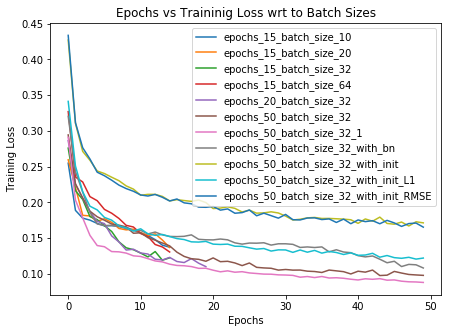

In [24]:
plt.figure (figsize=(7, 5))
for k, v in training_loss.items ():
    plt.plot (v)
plt.legend (training_loss.keys ())
plt.title ('Epochs vs Traininig Loss wrt to Batch Sizes')
plt.ylabel ('Training Loss'); plt.xlabel ('Epochs');

- Looks like the batch size of 32 is better
- The run `epochs_50_batch_size_32_1`, is similar to the one without `_1`, with the only difference being the updates on preprocessing
- The run `epochs_50_batch_size_32_with_int` has the following changes (in addition to what was done earlier)
    - Added RandomScale and RandomRotate as part of augmentation
    - Changed the initialization method to use He Initialization (or Kaiming Initialization)

**Note**: Batch size = 32 was run twice, once till 15 epochs and other with 20; the plot above compares other batch sizes until 15 epochs with batch size of 32 having the lowest losses

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.1344761   0.04869879 -0.0029577   0.03695176]
 [ 0.0486335   0.02859972 -0.00838041 -0.0610127 ]
 [-0.05779725 -0.05653564 -0.04115492 -0.07991505]
 [ 0.1485011  -0.01369831 -0.01266998 -0.09467915]]
(4, 4)


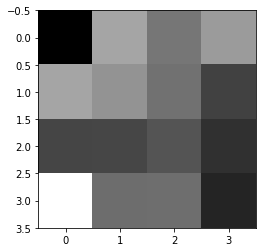

In [25]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy() if device == 'cpu' else weights1.cpu ().numpy ()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### Filter an image to see the effect of a convolutional kernel
---

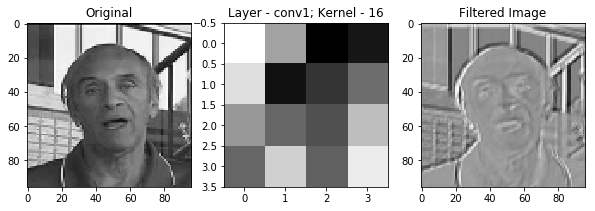

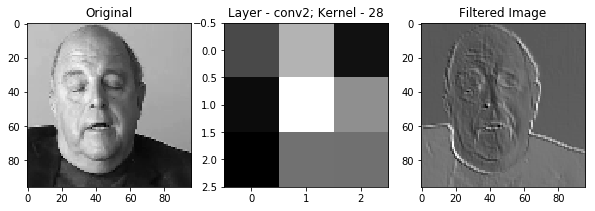

In [28]:
import cv2

def choose_conv_layers (selection):
    ''' Displays the output of each conv layer '''
    
    ##TODO: load in and display any image from the transformed test dataset
    data = next (iter (test_loader))
    img = data ['image'].numpy ()
    img = np.squeeze (img [0])

    ## TODO: Using cv's filter2D function,
    ## apply a specific set of filter weights (like the one displayed above) to the test image
    # Display the applications of the weights in the first conv layer
    weight = net.state_dict () [f'{selection}.weight'].data

    # Randomly select on the kernels
    idx = np.random.randint (0, weight.size (0))
    kernel = weight [idx] [0].numpy () if device == 'cpu' else weight [idx] [0].cpu ().numpy ()
    filtered_img = cv2.filter2D (img, -1, kernel)

    plt.figure (figsize=(10, 5))
    plt.subplot (131)
    plt.imshow (img, cmap='gray')
    plt.title ('Original')

    plt.subplot (132)
    plt.imshow (kernel, cmap='gray')
    plt.title (f'Layer - {selection}; Kernel - {idx+1}')

    plt.subplot (133)
    plt.imshow (filtered_img, cmap='gray')
    plt.title ('Filtered Image');
    
    plt.show ()
    
    
# Call the function on each of the conv layers
for layer in ['conv1', 'conv2']:
    choose_conv_layers (layer)

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The kernels (in the initial layer) tries to detect some of the edges (horizontal/vertical) and also tries to blur the images in some of the case (tried on multiple random kernels within a layer). Its filtering out the features that can help detect the keypoints (which should be the edges and corner of facial features (landmarks), that are distinguishable for a given person)

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!